## Assignment 8 by Agajan Torayev (matr.: 3067341), Joan Plepi (matr.: 3056655)

In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline

seed = 999
random.seed(seed)
torch.manual_seed(seed)

### Parameters

In [2]:
dataroot = "data/balls"
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64

### Prepare Data

Device:  cuda:0


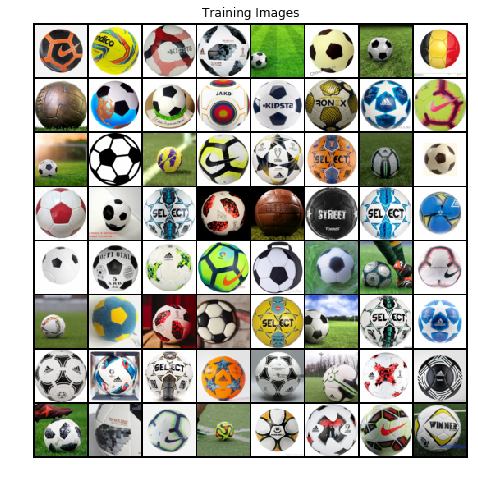

In [3]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                    shuffle=True, num_workers=2)

device = torch.device("cuda: 0" if torch.cuda.is_available()  else "cpu")
print("Device: ", device)

real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),
                       (1, 2, 0)))

### Weight initialization function

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator Network

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, input):
        return self.main(input)

netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### Discriminator Network

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)


### Training

In [7]:
num_epochs = 1000
lr = 0.0002
beta1 = 0.5

criterion = nn.BCELoss()

# noise to check performance
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# labels
real_label = 1
fake_label = 0

# separate optimizers for Discriminator and Generator
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader):
        
        # First update Discriminator Network
        # Maximize log(D(x)) + log(1-D(G(z)))
        # Train with real batches
        netD.zero_grad()
        
        # take only images
        real_data = data[0].to(device)
        bs = real_data.size(0)
        
        # by default dataloader has 0 for real labels, convert it to 1's
        label = torch.full((bs,), real_label, device=device)
        
        output = netD(real_data).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        
        # record average
        D_x = output.mean().item()

        # Now train discriminator with fake batches
        noise = torch.randn(bs, nz, 1, 1, device=device)
        
        # generate fake images
        fake = netG(noise)
        label.fill_(fake_label)
        
        # use detach to avoid calculating gradients on fake
        # we just need output of Discriminator at this point
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        
        # record average
        D_G_z1 = output.mean().item()
        
        # total error
        errD = errD_real + errD_fake
        optimizerD.step()
        
        # Second update Generator Network
        # Maximize log(D(G(z))) or minimize log(1-D(G(z)))
        # Maximizing log(D(G(z))) gives better gradient flow
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 100 == 0:
            print('Epoch [%d/%d], iters: %d\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch + 1, num_epochs, iters + 1,
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Epoch [1/1000], iters: 1	Loss_D: 1.8684	Loss_G: 4.9433	D(x): 0.5071	D(G(z)): 0.5749 / 0.0113
Epoch [2/1000], iters: 5	Loss_D: 0.4394	Loss_G: 6.6486	D(x): 0.8674	D(G(z)): 0.1911 / 0.0019
Epoch [3/1000], iters: 9	Loss_D: 0.3141	Loss_G: 7.4143	D(x): 0.8712	D(G(z)): 0.0993 / 0.0010
Epoch [4/1000], iters: 13	Loss_D: 0.2171	Loss_G: 8.3410	D(x): 0.8974	D(G(z)): 0.0506 / 0.0004
Epoch [5/1000], iters: 17	Loss_D: 0.2090	Loss_G: 10.3333	D(x): 0.8617	D(G(z)): 0.0080 / 0.0001
Epoch [6/1000], iters: 21	Loss_D: 0.1566	Loss_G: 9.9002	D(x): 0.8846	D(G(z)): 0.0077 / 0.0001
Epoch [7/1000], iters: 25	Loss_D: 2.1421	Loss_G: 23.7621	D(x): 0.9889	D(G(z)): 0.8386 / 0.0000
Epoch [8/1000], iters: 29	Loss_D: 0.3852	Loss_G: 14.1634	D(x): 0.9871	D(G(z)): 0.2761 / 0.0000
Epoch [9/1000], iters: 33	Loss_D: 0.8987	Loss_G: 25.8014	D(x): 0.5642	D(G(z)): 0.0000 / 0.0000
Epoch [10/1000], iters: 37	Loss_D: 1.8199	Loss_G: 26.0166	D(x): 0.9854	D(G(z)): 0.7927 / 0.0000
Epoch [11/1000], iters: 41	Loss_D: 0.0404	Loss_G: 24.9869

Epoch [86/1000], iters: 341	Loss_D: 0.3056	Loss_G: 4.5255	D(x): 0.8613	D(G(z)): 0.1088 / 0.0183
Epoch [87/1000], iters: 345	Loss_D: 0.2959	Loss_G: 4.2922	D(x): 0.7927	D(G(z)): 0.0274 / 0.0261
Epoch [88/1000], iters: 349	Loss_D: 1.5888	Loss_G: 9.6498	D(x): 0.9421	D(G(z)): 0.6749 / 0.0043
Epoch [89/1000], iters: 353	Loss_D: 0.1966	Loss_G: 5.1028	D(x): 0.8858	D(G(z)): 0.0541 / 0.0141
Epoch [90/1000], iters: 357	Loss_D: 0.3387	Loss_G: 4.0686	D(x): 0.9363	D(G(z)): 0.2149 / 0.0307
Epoch [91/1000], iters: 361	Loss_D: 0.5474	Loss_G: 4.9707	D(x): 0.6638	D(G(z)): 0.0087 / 0.0126
Epoch [92/1000], iters: 365	Loss_D: 0.3453	Loss_G: 3.3158	D(x): 0.8403	D(G(z)): 0.1261 / 0.0536
Epoch [93/1000], iters: 369	Loss_D: 0.2717	Loss_G: 3.3230	D(x): 0.8497	D(G(z)): 0.0751 / 0.0592
Epoch [94/1000], iters: 373	Loss_D: 0.4265	Loss_G: 5.1729	D(x): 0.9507	D(G(z)): 0.2712 / 0.0161
Epoch [95/1000], iters: 377	Loss_D: 0.3189	Loss_G: 2.9316	D(x): 0.8423	D(G(z)): 0.1132 / 0.0805
Epoch [96/1000], iters: 381	Loss_D: 0.87

Epoch [170/1000], iters: 677	Loss_D: 0.2508	Loss_G: 3.8691	D(x): 0.9110	D(G(z)): 0.1350 / 0.0314
Epoch [171/1000], iters: 681	Loss_D: 0.2711	Loss_G: 4.4809	D(x): 0.9530	D(G(z)): 0.1783 / 0.0206
Epoch [172/1000], iters: 685	Loss_D: 0.2503	Loss_G: 3.2263	D(x): 0.8234	D(G(z)): 0.0380 / 0.0637
Epoch [173/1000], iters: 689	Loss_D: 0.2275	Loss_G: 4.2908	D(x): 0.9469	D(G(z)): 0.1406 / 0.0299
Epoch [174/1000], iters: 693	Loss_D: 0.2816	Loss_G: 2.7524	D(x): 0.7961	D(G(z)): 0.0299 / 0.1008
Epoch [175/1000], iters: 697	Loss_D: 0.2450	Loss_G: 4.2655	D(x): 0.9354	D(G(z)): 0.1522 / 0.0229
Epoch [176/1000], iters: 701	Loss_D: 0.3156	Loss_G: 2.6207	D(x): 0.7610	D(G(z)): 0.0213 / 0.1227
Epoch [177/1000], iters: 705	Loss_D: 0.1769	Loss_G: 3.8185	D(x): 0.8999	D(G(z)): 0.0638 / 0.0407
Epoch [178/1000], iters: 709	Loss_D: 0.1892	Loss_G: 3.4596	D(x): 0.9100	D(G(z)): 0.0837 / 0.0544
Epoch [179/1000], iters: 713	Loss_D: 0.3143	Loss_G: 5.0617	D(x): 0.9397	D(G(z)): 0.1991 / 0.0147
Epoch [180/1000], iters: 717	L

Epoch [254/1000], iters: 1013	Loss_D: 3.1522	Loss_G: 6.6019	D(x): 0.9592	D(G(z)): 0.8032 / 0.0239
Epoch [255/1000], iters: 1017	Loss_D: 1.2775	Loss_G: 5.7668	D(x): 0.8469	D(G(z)): 0.5334 / 0.0126
Epoch [256/1000], iters: 1021	Loss_D: 1.2306	Loss_G: 5.7651	D(x): 0.9204	D(G(z)): 0.5529 / 0.0102
Epoch [257/1000], iters: 1025	Loss_D: 0.6059	Loss_G: 4.9899	D(x): 0.8282	D(G(z)): 0.2304 / 0.0196
Epoch [258/1000], iters: 1029	Loss_D: 0.3542	Loss_G: 3.8183	D(x): 0.8599	D(G(z)): 0.1535 / 0.0416
Epoch [259/1000], iters: 1033	Loss_D: 0.3333	Loss_G: 3.4250	D(x): 0.7799	D(G(z)): 0.0552 / 0.0559
Epoch [260/1000], iters: 1037	Loss_D: 0.1650	Loss_G: 4.4232	D(x): 0.9200	D(G(z)): 0.0720 / 0.0222
Epoch [261/1000], iters: 1041	Loss_D: 0.3135	Loss_G: 5.1341	D(x): 0.9605	D(G(z)): 0.2134 / 0.0109
Epoch [262/1000], iters: 1045	Loss_D: 0.2192	Loss_G: 4.7688	D(x): 0.9459	D(G(z)): 0.1374 / 0.0136
Epoch [263/1000], iters: 1049	Loss_D: 0.1850	Loss_G: 4.1628	D(x): 0.9078	D(G(z)): 0.0772 / 0.0268
Epoch [264/1000], it

Epoch [337/1000], iters: 1345	Loss_D: 0.0865	Loss_G: 3.8984	D(x): 0.9520	D(G(z)): 0.0358 / 0.0281
Epoch [338/1000], iters: 1349	Loss_D: 0.0932	Loss_G: 3.9631	D(x): 0.9612	D(G(z)): 0.0507 / 0.0281
Epoch [339/1000], iters: 1353	Loss_D: 0.0885	Loss_G: 4.2856	D(x): 0.9579	D(G(z)): 0.0432 / 0.0209
Epoch [340/1000], iters: 1357	Loss_D: 0.0733	Loss_G: 4.0454	D(x): 0.9564	D(G(z)): 0.0275 / 0.0261
Epoch [341/1000], iters: 1361	Loss_D: 0.0876	Loss_G: 4.5479	D(x): 0.9680	D(G(z)): 0.0519 / 0.0170
Epoch [342/1000], iters: 1365	Loss_D: 0.0775	Loss_G: 4.1647	D(x): 0.9659	D(G(z)): 0.0409 / 0.0234
Epoch [343/1000], iters: 1369	Loss_D: 0.1346	Loss_G: 4.9534	D(x): 0.9805	D(G(z)): 0.1034 / 0.0117
Epoch [344/1000], iters: 1373	Loss_D: 0.0744	Loss_G: 4.3634	D(x): 0.9488	D(G(z)): 0.0205 / 0.0210
Epoch [345/1000], iters: 1377	Loss_D: 0.0919	Loss_G: 4.2921	D(x): 0.9729	D(G(z)): 0.0598 / 0.0199
Epoch [346/1000], iters: 1381	Loss_D: 0.0789	Loss_G: 4.0946	D(x): 0.9553	D(G(z)): 0.0318 / 0.0255
Epoch [347/1000], it

Epoch [420/1000], iters: 1677	Loss_D: 0.0633	Loss_G: 4.2225	D(x): 0.9772	D(G(z)): 0.0387 / 0.0208
Epoch [421/1000], iters: 1681	Loss_D: 0.1157	Loss_G: 4.7644	D(x): 0.9838	D(G(z)): 0.0897 / 0.0133
Epoch [422/1000], iters: 1685	Loss_D: 0.0655	Loss_G: 4.2198	D(x): 0.9748	D(G(z)): 0.0385 / 0.0204
Epoch [423/1000], iters: 1689	Loss_D: 0.0617	Loss_G: 4.2513	D(x): 0.9751	D(G(z)): 0.0347 / 0.0212
Epoch [424/1000], iters: 1693	Loss_D: 0.0650	Loss_G: 4.1606	D(x): 0.9786	D(G(z)): 0.0416 / 0.0219
Epoch [425/1000], iters: 1697	Loss_D: 0.0620	Loss_G: 4.2048	D(x): 0.9638	D(G(z)): 0.0242 / 0.0220
Epoch [426/1000], iters: 1701	Loss_D: 0.0501	Loss_G: 4.3798	D(x): 0.9775	D(G(z)): 0.0266 / 0.0178
Epoch [427/1000], iters: 1705	Loss_D: 0.0608	Loss_G: 4.4817	D(x): 0.9814	D(G(z)): 0.0402 / 0.0164
Epoch [428/1000], iters: 1709	Loss_D: 0.0630	Loss_G: 4.3581	D(x): 0.9673	D(G(z)): 0.0284 / 0.0190
Epoch [429/1000], iters: 1713	Loss_D: 0.0569	Loss_G: 4.2041	D(x): 0.9671	D(G(z)): 0.0227 / 0.0217
Epoch [430/1000], it

Epoch [503/1000], iters: 2009	Loss_D: 0.4312	Loss_G: 4.8664	D(x): 0.8698	D(G(z)): 0.1493 / 0.0207
Epoch [504/1000], iters: 2013	Loss_D: 1.0693	Loss_G: 5.1275	D(x): 0.5192	D(G(z)): 0.0144 / 0.0302
Epoch [505/1000], iters: 2017	Loss_D: 0.2745	Loss_G: 5.0034	D(x): 0.9508	D(G(z)): 0.1633 / 0.0185
Epoch [506/1000], iters: 2021	Loss_D: 0.2260	Loss_G: 5.4019	D(x): 0.8431	D(G(z)): 0.0311 / 0.0137
Epoch [507/1000], iters: 2025	Loss_D: 0.1756	Loss_G: 4.4183	D(x): 0.9418	D(G(z)): 0.0990 / 0.0218
Epoch [508/1000], iters: 2029	Loss_D: 0.3688	Loss_G: 7.0527	D(x): 0.9790	D(G(z)): 0.2553 / 0.0023
Epoch [509/1000], iters: 2033	Loss_D: 0.1370	Loss_G: 5.0521	D(x): 0.9389	D(G(z)): 0.0611 / 0.0119
Epoch [510/1000], iters: 2037	Loss_D: 0.1449	Loss_G: 4.7135	D(x): 0.9577	D(G(z)): 0.0909 / 0.0149
Epoch [511/1000], iters: 2041	Loss_D: 0.1490	Loss_G: 4.5052	D(x): 0.9533	D(G(z)): 0.0904 / 0.0169
Epoch [512/1000], iters: 2045	Loss_D: 0.1203	Loss_G: 4.4793	D(x): 0.9548	D(G(z)): 0.0679 / 0.0182
Epoch [513/1000], it

Epoch [586/1000], iters: 2341	Loss_D: 0.0309	Loss_G: 4.8211	D(x): 0.9871	D(G(z)): 0.0176 / 0.0125
Epoch [587/1000], iters: 2345	Loss_D: 0.0320	Loss_G: 4.7575	D(x): 0.9846	D(G(z)): 0.0162 / 0.0132
Epoch [588/1000], iters: 2349	Loss_D: 0.0279	Loss_G: 5.0822	D(x): 0.9916	D(G(z)): 0.0190 / 0.0097
Epoch [589/1000], iters: 2353	Loss_D: 0.0221	Loss_G: 5.0086	D(x): 0.9899	D(G(z)): 0.0118 / 0.0097
Epoch [590/1000], iters: 2357	Loss_D: 0.0419	Loss_G: 4.7738	D(x): 0.9913	D(G(z)): 0.0321 / 0.0122
Epoch [591/1000], iters: 2361	Loss_D: 0.0324	Loss_G: 4.6198	D(x): 0.9865	D(G(z)): 0.0185 / 0.0144
Epoch [592/1000], iters: 2365	Loss_D: 0.0296	Loss_G: 4.8079	D(x): 0.9878	D(G(z)): 0.0170 / 0.0120
Epoch [593/1000], iters: 2369	Loss_D: 0.0295	Loss_G: 4.9573	D(x): 0.9893	D(G(z)): 0.0184 / 0.0104
Epoch [594/1000], iters: 2373	Loss_D: 0.0256	Loss_G: 5.1299	D(x): 0.9857	D(G(z)): 0.0110 / 0.0096
Epoch [595/1000], iters: 2377	Loss_D: 0.0345	Loss_G: 4.9017	D(x): 0.9775	D(G(z)): 0.0115 / 0.0116
Epoch [596/1000], it

Epoch [669/1000], iters: 2673	Loss_D: 0.0212	Loss_G: 4.9223	D(x): 0.9948	D(G(z)): 0.0157 / 0.0108
Epoch [670/1000], iters: 2677	Loss_D: 0.0228	Loss_G: 5.0867	D(x): 0.9918	D(G(z)): 0.0142 / 0.0095
Epoch [671/1000], iters: 2681	Loss_D: 0.0179	Loss_G: 5.1966	D(x): 0.9916	D(G(z)): 0.0094 / 0.0083
Epoch [672/1000], iters: 2685	Loss_D: 0.0204	Loss_G: 5.2839	D(x): 0.9913	D(G(z)): 0.0115 / 0.0080
Epoch [673/1000], iters: 2689	Loss_D: 0.0187	Loss_G: 5.2583	D(x): 0.9902	D(G(z)): 0.0087 / 0.0080
Epoch [674/1000], iters: 2693	Loss_D: 0.0223	Loss_G: 5.3773	D(x): 0.9854	D(G(z)): 0.0075 / 0.0085
Epoch [675/1000], iters: 2697	Loss_D: 0.0196	Loss_G: 5.0808	D(x): 0.9908	D(G(z)): 0.0102 / 0.0099
Epoch [676/1000], iters: 2701	Loss_D: 0.0210	Loss_G: 5.2245	D(x): 0.9919	D(G(z)): 0.0126 / 0.0085
Epoch [677/1000], iters: 2705	Loss_D: 0.0213	Loss_G: 5.1173	D(x): 0.9915	D(G(z)): 0.0126 / 0.0086
Epoch [678/1000], iters: 2709	Loss_D: 0.0202	Loss_G: 5.3757	D(x): 0.9946	D(G(z)): 0.0145 / 0.0071
Epoch [679/1000], it

Epoch [752/1000], iters: 3005	Loss_D: 0.0244	Loss_G: 6.1728	D(x): 0.9964	D(G(z)): 0.0197 / 0.0036
Epoch [753/1000], iters: 3009	Loss_D: 0.0177	Loss_G: 5.6585	D(x): 0.9898	D(G(z)): 0.0073 / 0.0061
Epoch [754/1000], iters: 3013	Loss_D: 0.0142	Loss_G: 5.7496	D(x): 0.9936	D(G(z)): 0.0077 / 0.0055
Epoch [755/1000], iters: 3017	Loss_D: 0.0152	Loss_G: 5.4961	D(x): 0.9950	D(G(z)): 0.0101 / 0.0064
Epoch [756/1000], iters: 3021	Loss_D: 0.0157	Loss_G: 5.3282	D(x): 0.9887	D(G(z)): 0.0044 / 0.0070
Epoch [757/1000], iters: 3025	Loss_D: 0.0175	Loss_G: 5.6411	D(x): 0.9952	D(G(z)): 0.0124 / 0.0059
Epoch [758/1000], iters: 3029	Loss_D: 0.0150	Loss_G: 5.3177	D(x): 0.9945	D(G(z)): 0.0093 / 0.0072
Epoch [759/1000], iters: 3033	Loss_D: 0.0136	Loss_G: 5.6371	D(x): 0.9908	D(G(z)): 0.0043 / 0.0055
Epoch [760/1000], iters: 3037	Loss_D: 0.0127	Loss_G: 5.6380	D(x): 0.9953	D(G(z)): 0.0079 / 0.0057
Epoch [761/1000], iters: 3041	Loss_D: 0.0142	Loss_G: 5.4868	D(x): 0.9925	D(G(z)): 0.0066 / 0.0063
Epoch [762/1000], it

Epoch [835/1000], iters: 3337	Loss_D: 0.0391	Loss_G: 4.9863	D(x): 0.9850	D(G(z)): 0.0233 / 0.0100
Epoch [836/1000], iters: 3341	Loss_D: 0.0375	Loss_G: 5.1500	D(x): 0.9846	D(G(z)): 0.0212 / 0.0095
Epoch [837/1000], iters: 3345	Loss_D: 0.0371	Loss_G: 5.2936	D(x): 0.9810	D(G(z)): 0.0174 / 0.0102
Epoch [838/1000], iters: 3349	Loss_D: 0.0417	Loss_G: 5.8339	D(x): 0.9899	D(G(z)): 0.0300 / 0.0049
Epoch [839/1000], iters: 3353	Loss_D: 0.0302	Loss_G: 5.6905	D(x): 0.9871	D(G(z)): 0.0167 / 0.0060
Epoch [840/1000], iters: 3357	Loss_D: 0.0316	Loss_G: 5.2954	D(x): 0.9837	D(G(z)): 0.0149 / 0.0088
Epoch [841/1000], iters: 3361	Loss_D: 0.0303	Loss_G: 5.2048	D(x): 0.9846	D(G(z)): 0.0145 / 0.0089
Epoch [842/1000], iters: 3365	Loss_D: 0.0290	Loss_G: 5.2353	D(x): 0.9878	D(G(z)): 0.0158 / 0.0089
Epoch [843/1000], iters: 3369	Loss_D: 0.0256	Loss_G: 5.0864	D(x): 0.9842	D(G(z)): 0.0094 / 0.0095
Epoch [844/1000], iters: 3373	Loss_D: 0.0295	Loss_G: 5.2130	D(x): 0.9837	D(G(z)): 0.0127 / 0.0090
Epoch [845/1000], it

Epoch [918/1000], iters: 3669	Loss_D: 0.0150	Loss_G: 5.5640	D(x): 0.9941	D(G(z)): 0.0089 / 0.0060
Epoch [919/1000], iters: 3673	Loss_D: 0.0160	Loss_G: 5.6388	D(x): 0.9944	D(G(z)): 0.0103 / 0.0061
Epoch [920/1000], iters: 3677	Loss_D: 0.0165	Loss_G: 5.5455	D(x): 0.9926	D(G(z)): 0.0089 / 0.0066
Epoch [921/1000], iters: 3681	Loss_D: 0.0192	Loss_G: 5.6103	D(x): 0.9960	D(G(z)): 0.0148 / 0.0060
Epoch [922/1000], iters: 3685	Loss_D: 0.0217	Loss_G: 5.6887	D(x): 0.9956	D(G(z)): 0.0169 / 0.0056
Epoch [923/1000], iters: 3689	Loss_D: 0.0139	Loss_G: 5.6179	D(x): 0.9965	D(G(z)): 0.0103 / 0.0053
Epoch [924/1000], iters: 3693	Loss_D: 0.0121	Loss_G: 5.6024	D(x): 0.9950	D(G(z)): 0.0070 / 0.0055
Epoch [925/1000], iters: 3697	Loss_D: 0.0162	Loss_G: 5.4156	D(x): 0.9911	D(G(z)): 0.0072 / 0.0072
Epoch [926/1000], iters: 3701	Loss_D: 0.0150	Loss_G: 5.6939	D(x): 0.9930	D(G(z)): 0.0079 / 0.0062
Epoch [927/1000], iters: 3705	Loss_D: 0.0160	Loss_G: 5.5446	D(x): 0.9911	D(G(z)): 0.0071 / 0.0066
Epoch [928/1000], it

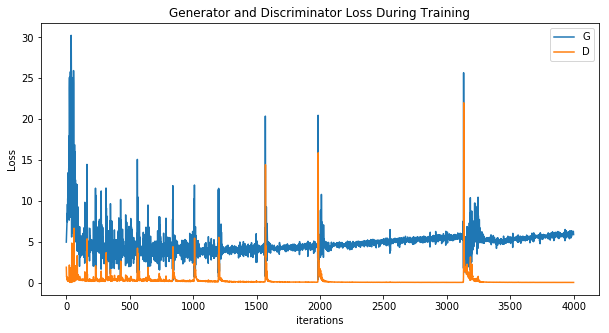

In [8]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

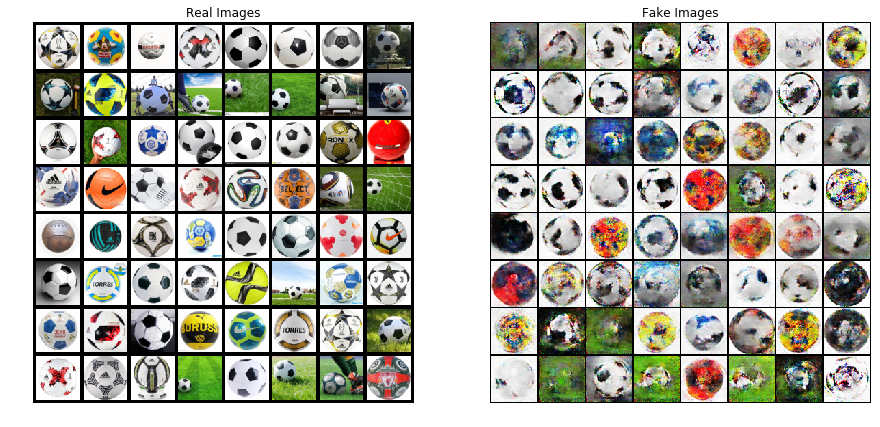

In [9]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()